In [1]:
# import all libraries and modules needed
import os
import sys
import datetime
import glob
import keras
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

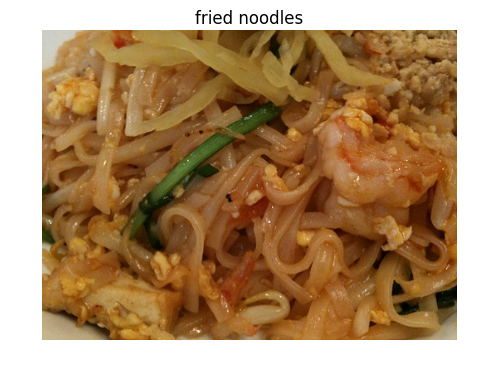

In [5]:
img = load_img('data/train/noodles_fried/4012787089_d1cca54838.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('fried noodles')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

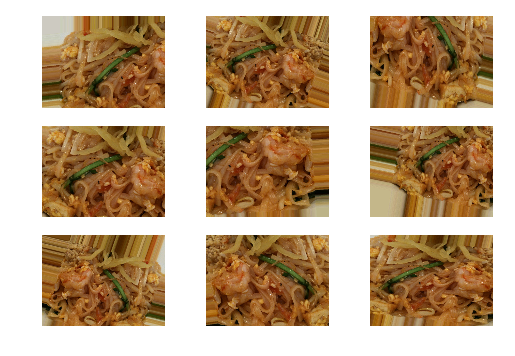

In [7]:
i = 0
fig = plt.figure()
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

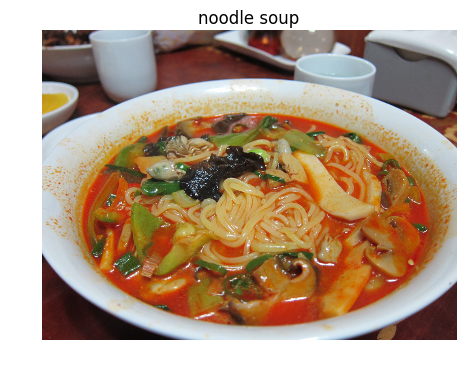

In [8]:
img = load_img('data/train/noodle_soup/5153183161_eb845fb8d9_b.jpg')
plt.imshow(img)
plt.axis('off')
plt.title('noodle soup')
plt.show()

In [9]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20
batch_size = 32
nb_classes = len(glob.glob(train_dir + '/*'))

In [10]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

315


In [11]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

36


In [12]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [13]:
# data pre-processing for validating
validate_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 315 images belonging to 2 classes.


In [15]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 36 images belonging to 2 classes.


In [16]:
# set up transfer learning on pre-trained ImageNet Xception model - remove fully connected layer and replace
# with softmax for classifying 2 classes
xcep_model = Xception(weights = 'imagenet', include_top = False, input_shape =(img_width, img_height, 3))
x = xcep_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = xcep_model.input, output = predictions)

In [17]:
# freeze all layers of the pre-trained model
for layer in xcep_model.layers:
    layer.trainable = False

In [18]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy'])

In [19]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
315/315 [==============================] - 264s - loss: 2.0026 - acc: 0.6571 - val_loss: 0.6340 - val_acc: 0.7222
Epoch 2/20
315/315 [==============================] - 260s - loss: 0.5182 - acc: 0.7746 - val_loss: 0.2901 - val_acc: 0.9444
Epoch 3/20
315/315 [==============================] - 253s - loss: 0.3205 - acc: 0.8698 - val_loss: 0.3750 - val_acc: 0.8333
Epoch 4/20
315/315 [==============================] - 252s - loss: 0.4911 - acc: 0.7937 - val_loss: 0.5513 - val_acc: 0.7500
Epoch 5/20
315/315 [==============================] - 253s - loss: 0.3513 - acc: 0.8317 - val_loss: 0.1772 - val_acc: 0.9167
Epoch 6/20
315/315 [==============================] - 253s - loss: 0.2965 - acc: 0.8794 - val_loss: 0.4919 - val_acc: 0.8056
Epoch 7/20
315/315 [==============================] - 253s - loss: 0.4814 - acc: 0.7937 - val_loss: 0.2713 - val_acc: 0.9167
Epoch 8/20
315/315 [==============================] - 253s - loss: 0.2291 - acc: 0.9143 - val_loss: 0.3256 - val_acc: 0.8889


In [20]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.232730045915
Test Accuracy: 0.875


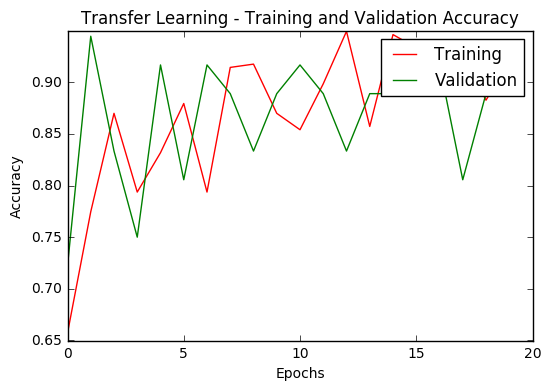

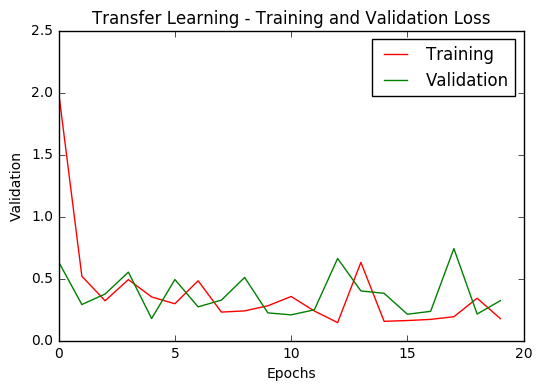

In [21]:
# plot the accuracy and loss data
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

plt.figure()
plt.plot(epochs, xfer_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, xfer_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Validation")
plt.legend()
plt.show()

In [22]:
# display the layers in the pretrained model
for i, layer in enumerate(xcep_model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 convolution2d_1
13 block2_pool
14 batchnormalization_1
15 merge_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 convolution2d_2
23 block3_pool
24 batchnormalization_2
25 merge_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 convolution2d_3
33 block4_pool
34 batchnormalization_3
35 merge_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 merge_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_se

In [23]:
# display the details of the model
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [24]:
# Step 1 - Set up fine tuning on pre-trained ImageNet Xception model - freeze lower 94 layers only
for layer in model.layers[:94]:
    layer.trainable = False
for layer in model.layers[94:]:
    layer.trainable = True

# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
315/315 [==============================] - 330s - loss: 0.1190 - acc: 0.9556 - val_loss: 0.1710 - val_acc: 0.9167
Epoch 2/20
315/315 [==============================] - 324s - loss: 0.1023 - acc: 0.9651 - val_loss: 0.4119 - val_acc: 0.8611
Epoch 3/20
315/315 [==============================] - 324s - loss: 0.1007 - acc: 0.9556 - val_loss: 0.3045 - val_acc: 0.9167
Epoch 4/20
315/315 [==============================] - 324s - loss: 0.1082 - acc: 0.9460 - val_loss: 0.3031 - val_acc: 0.9167
Epoch 5/20
315/315 [==============================] - 324s - loss: 0.1524 - acc: 0.9429 - val_loss: 0.1970 - val_acc: 0.9167
Epoch 6/20
315/315 [==============================] - 323s - loss: 0.1116 - acc: 0.9492 - val_loss: 0.2957 - val_acc: 0.8889
Epoch 7/20
315/315 [==============================] - 324s - loss: 0.0838 - acc: 0.9651 - val_loss: 0.3093 - val_acc: 0.8889
Epoch 8/20
315/315 [==============================] - 323s - loss: 0.1160 - acc: 0.9556 - val_loss: 0.2100 - val_acc: 0.8889


In [25]:
# evaluate the performance the revised model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size, pickle_safe=False)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0245872102678
Test Accuracy: 1.0


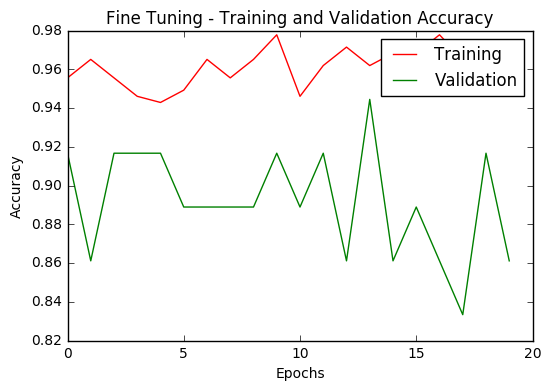

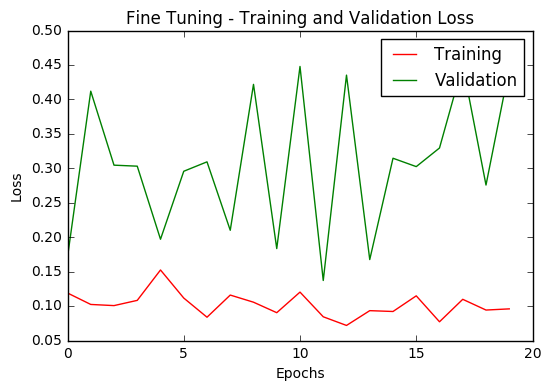

In [26]:
# plot the accuracy and loss data
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

plt.plot(epochs, ft_acc, 'r-', label = 'Training')
plt.plot(epochs, val_acc, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, ft_loss, 'r-', label = 'Training')
plt.plot(epochs, val_loss, 'g-', label = 'Validation')
plt.title('Fine Tuning - Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()